In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

#!pip install tensorflow==1.14.0
!pip install Keras==2.3.0

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers


     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


# Data Preparation

In [3]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/combined2.csv"
df = pd.read_csv(dataset_path)

del df['Hour']
del df['Date']

print (df)

       Day  TimeSlot  Weekend  ...        CO2  HumidityRatio  Occupancy
0        2         2        0  ...   5.235582      10.795786          1
1        2         2        0  ...   5.343291      10.831549          1
2        2         2        0  ...   5.432407      10.799950          1
3        2         2        0  ...   5.481292      10.709977          1
4        2         2        0  ...   5.522164      10.806016          1
...    ...       ...      ...  ...        ...            ...        ...
20555   18         1        0  ...  12.506386       8.476117          1
20556   18         1        0  ...  12.595342       8.548897          1
20557   18         1        0  ...  12.662660       8.576488          1
20558   18         1        0  ...  13.725319       8.756051          1
20559   18         1        0  ...  15.956424       8.929634          1

[20560 rows x 10 columns]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('./')

In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [7]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,15.957720,8.711492,7.452585,5.343291,10.831549,1
2,2,2,0,1,15.993220,8.669303,7.398537,5.432407,10.799950,1
3,2,2,0,1,15.971032,8.595474,6.654588,5.481292,10.709977,1
4,2,2,0,1,16.064222,8.648209,6.606039,5.522164,10.806016,1


# Data Partitioning

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)



# Normalization

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# DEEP NEURAL NETWORK

## modello 1

come primo modello è stato creata una deep neural network composta da 7 hidden layers di dimensioni differenti, tutti però accomunati dalla funzione di attivazione sigmoid.
sono stati aggiunti due regolarizzatori dropout in corrispondenza del secondo e del terzo hidden layer. 
è stato inoltre aggiunto un criterio di early stopping bilanciato in base alla variazione del valore loss. 
si nota un assestamento della discesa della curva per un certo numero di epoche, per poi riprendere fino al raggiungimento del valore minimo di convergenza.
accuracy elevata 99% e con early stop ci si ferma intorno all'epoca 350.

Train on 9210 samples, validate on 2303 samples
Epoch 1/500
9210/9210 [==============================] - 0s 35us/step - loss: 0.6397 - accuracy: 0.7699 - val_loss: 0.6327 - val_accuracy: 0.7660
Epoch 2/500
9210/9210 [==============================] - 0s 7us/step - loss: 0.6252 - accuracy: 0.7699 - val_loss: 0.6193 - val_accuracy: 0.7660
Epoch 3/500
9210/9210 [==============================] - 0s 8us/step - loss: 0.6125 - accuracy: 0.7699 - val_loss: 0.6078 - val_accuracy: 0.7660
Epoch 4/500
9210/9210 [==============================] - 0s 7us/step - loss: 0.6015 - accuracy: 0.7699 - val_loss: 0.5978 - val_accuracy: 0.7660
Epoch 5/500
9210/9210 [==============================] - 0s 6us/step - loss: 0.5921 - accuracy: 0.7699 - val_loss: 0.5892 - val_accuracy: 0.7660
Epoch 6/500
9210/9210 [==============================] - 0s 6us/step - loss: 0.5839 - accuracy: 0.7699 - val_loss: 0.5821 - val_accuracy: 0.7660
Epoch 7/500
9210/9210 [==============================] - 0s 7us/step - loss: 0.57

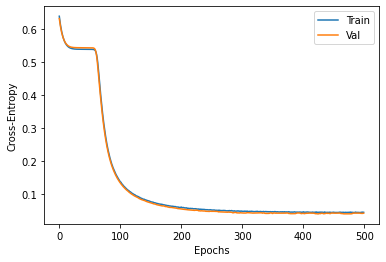

In [69]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

a = optimizers.SGD(learning_rate=1, momentum=0.4)
b = optimizers.adam(learning_rate=0.001)

def build_model1():
    
    n_feature = X_train.shape[1]

    model = Sequential()
    model.add(Dense(1, input_dim=n_feature, activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(4, activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=b, metrics=['accuracy'])
    return model

model1 = build_model1()

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=500).history

plt.plot(history1['loss'], label='Train')
plt.plot(history1['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

6168/6168 [==============================] - 0s 23us/step
Test results - Loss: 0.0443719528487433 - Accuracy: 0.9901102185249329%


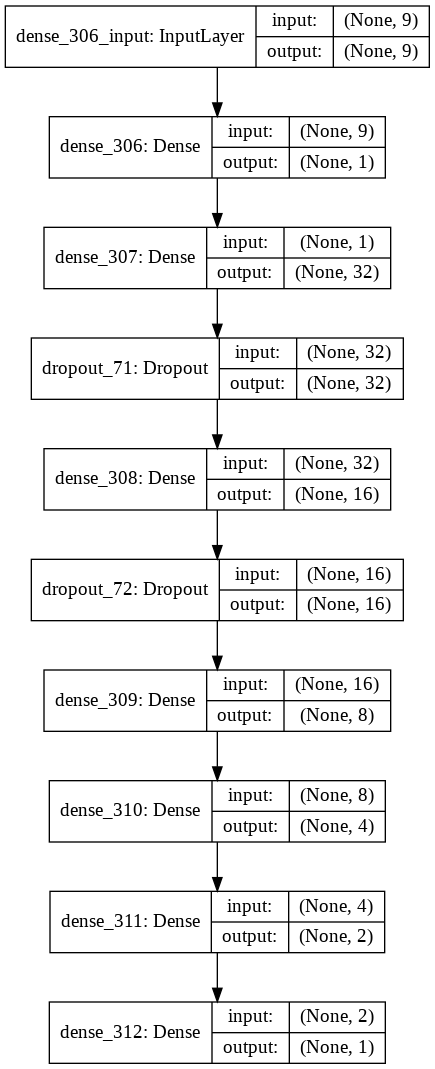

In [70]:
# Test the model after training
test_results = model1.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

from keras.utils.vis_utils import plot_model
plot_model(model1, show_shapes=True, show_layer_names=True)


## modello 2

Train on 11513 samples, validate on 6168 samples
Epoch 1/100
11513/11513 [==============================] - 0s 17us/step - loss: 0.5404 - accuracy: 0.7691 - val_loss: 0.5405 - val_accuracy: 0.7690
Epoch 2/100
11513/11513 [==============================] - 0s 17us/step - loss: 0.5403 - accuracy: 0.7691 - val_loss: 0.5405 - val_accuracy: 0.7690
Epoch 3/100
11513/11513 [==============================] - 0s 17us/step - loss: 0.5403 - accuracy: 0.7691 - val_loss: 0.5405 - val_accuracy: 0.7690
Epoch 4/100
11513/11513 [==============================] - 0s 17us/step - loss: 0.5403 - accuracy: 0.7691 - val_loss: 0.5405 - val_accuracy: 0.7690
Epoch 5/100
11513/11513 [==============================] - 0s 17us/step - loss: 0.5403 - accuracy: 0.7691 - val_loss: 0.5405 - val_accuracy: 0.7690
Epoch 6/100
11513/11513 [==============================] - 0s 17us/step - loss: 0.5403 - accuracy: 0.7691 - val_loss: 0.5405 - val_accuracy: 0.7690
Epoch 7/100
11513/11513 [==============================] - 0s 1

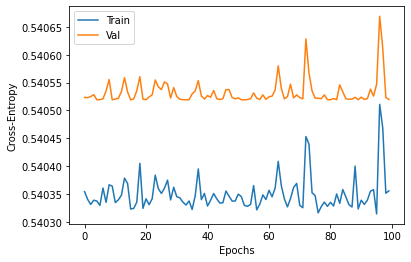

In [38]:
a = optimizers.SGD(learning_rate=1, momentum=0.4)
b = optimizers.adam(learning_rate=0.001)

def build_model2():
    
    n_feature = X_train.shape[1]

    model = Sequential()
    model.add(Dense(300, input_dim=n_feature, activation='relu'))
    model.add(Dense(150, input_dim=n_feature, activation='softmax'))
    model.add(Dense(10, input_dim=n_feature, activation='relu'))
    model.add(Dense(8, input_dim=n_feature, activation='sigmoid'))
    model.add(Dense(5, input_dim=n_feature, activation='relu'))
    model.add(Dense(4, input_dim=n_feature, activation='sigmoid'))
    model.add(Dense(3, input_dim=n_feature, activation='relu'))
    model.add(Dense(2, input_dim=n_feature, activation='sigmoid'))
    model.add(Dense(1, input_dim=n_feature, activation='sigmoid'))


    
    model.compile(loss='binary_crossentropy', optimizer=a, metrics=['accuracy'])
    return model



model2 = build_model2()
history2 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=500).history

plt.plot(history2['loss'], label='Train')
plt.plot(history2['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

6168/6168 [==============================] - 0s 27us/step
Test results - Loss: 0.7034282682006925 - Accuracy: 0.231031134724617%


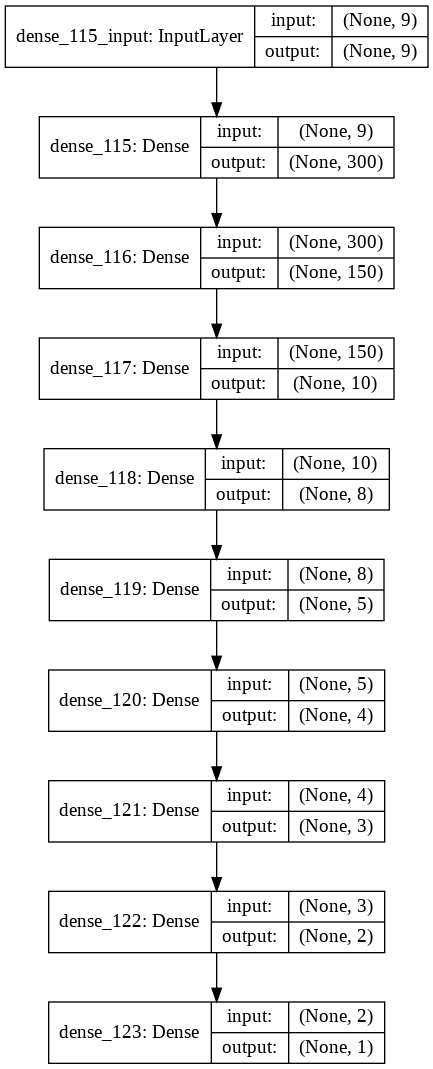

In [39]:
# Test the model after training
test_results = model2.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

from keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True)

## confronto

In [71]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 29us/step
Loss 0.044372, Accuracy 0.990110
Loss 0.703428, Accuracy 0.231031


## Early Stopping

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [0]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

In [0]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

## L2 Regularization

In [0]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

In [0]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

In [0]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

In [0]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

## Hyper-Parameter Tuning

In [0]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [0]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [0]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [0]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

In [0]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

In [0]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))